# **Project 1**, MIE1626 Winter 2022
**Data Science Methods and Quantitative Analysis - Home Credit Default Risk [90 Marks]**

**Deadline: February 11 at 21:00**

**Academic Integrity**

This project is individual: It is to be completed on your own. Do not share your code with others, or post any parts of your work online. You can only submit code that you have written yourself. If you use any online resource for developing parts of your code, acknowledge the source in a comment in your code. Students suspected of plagiarism on a project will be referred to the university for formal discipline according to the Code of Behaviour on Academic Matters.

Please fill out the following:


*   Name: Kasra Hamzehi
*   Student Number: 999680457
*   UTorID: hamzehia

## **Part 1: Getting started [20 Marks]**

* Load the data

Load the six csv files as pandas dataframes using a string 'path' for the location of files on your system (to be then updated by the marker for evaluation)

In [116]:
# Import necessary packages
import pandas as pd
import numpy as np
import math
from varclushi import VarClusHi

from sklearn import feature_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, f1_score, precision_score, recall_score, auc, roc_curve, confusion_matrix, classification_report

import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from xgboost import XGBClassifier, plot_importance

import sys

In [117]:
### YOUR CODE HERE ###
#load data as dataframes
application_train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')

* 1.1 Data transformation and cleaning [15 Marks]

To conduct data cleaning, the first step is create and select relevant features. This includes the
following sub-steps:
1. Remove/disregard features that have a constant value.
2. Remove/disregard features that are irrelevant to credit risk or can’t be explained. This includes
time variables that are only related to the application and other variables that are not related to
the response.
3. Handle missing values.
4. Calculate the proportion of each outcome in dichotomous value to transform categorical variables
to continuous variables (explained below).
5. Create new variables.

See details in the project handout. 

Cleaning bureau_balance.csv

In [118]:
# remove MONTHS_BALANCE 
bureau_balance_new = bureau_balance
del bureau_balance_new['MONTHS_BALANCE']

# calculate proportion of 0 in STATUS
proportion_bureau_balance = bureau_balance['STATUS'].value_counts(normalize=True)*100
proportion_is_0 = proportion_bureau_balance[1]
print("Proportion of 0 in the STATUS of balance_bureau is: {} ".format(proportion_is_0))

# merge with bureau using the key 'SK_ID_BUREAU'
bureau_combined = bureau.merge(bureau_balance_new, on='SK_ID_BUREAU', how='left')



Proportion of 0 in the STATUS of balance_bureau is: 27.470797080944358 


Cleaning bureau.csv

In [119]:
# calculate the proportion of Closed and Active of CREDIT_ACTIVE
proportion_active_closed = bureau_combined['CREDIT_ACTIVE'].value_counts(normalize=True)*100
print("proportion of ACTIVE and CLOSED in CREDIT_ACTIVE: ")
print(proportion_active_closed)

# remove CREDIT_CURRENCY as it is constant

del bureau_combined['CREDIT_CURRENCY']

# remove irrelevant variables 
bureau_combined.drop(['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE' , 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'], axis=1, inplace=True)

# calculate the proportion of consumer credit and credit card of CREDIT_TYPE
proportion_credit = bureau_combined['CREDIT_TYPE'].value_counts(normalize=True)*100
#print("proportion of consumer vs credit card: ")
print(proportion_credit)

#create new column, if loan is credit card then 1, 0 if else
bureau_combined['CREDIT_TYPE_CREDIT_CARD'] = 0
bureau_combined.loc[bureau_combined['CREDIT_TYPE'] == 'Credit card', 'CREDIT_TYPE_CREDIT_CARD'] =1

# calculate the average of the numerical variables for SK_ID_CURR and remove nuisance features that are qualitative
bureau_new = bureau_combined.groupby(['SK_ID_CURR'], as_index=False).mean()
bureau_new.loc[bureau_new['CREDIT_TYPE_CREDIT_CARD'] > 0, 'CREDIT_TYPE_CREDIT_CARD'] =1



#merge with application_train
application_train_new = application_train.merge(bureau_new, on='SK_ID_CURR', how='left')


proportion of ACTIVE and CLOSED in CREDIT_ACTIVE: 
Closed      76.035525
Active      23.463675
Sold         0.500330
Bad debt     0.000470
Name: CREDIT_ACTIVE, dtype: float64
Consumer credit                                 75.718004
Credit card                                     20.863540
Car loan                                         1.839389
Mortgage                                         1.039009
Microloan                                        0.213066
Loan for business development                    0.173741
Another type of loan                             0.071181
Unknown type of loan                             0.053587
Loan for working capital replenishment           0.020249
Cash loan (non-earmarked)                        0.005752
Loan for the purchase of equipment               0.001202
Real estate loan                                 0.001019
Loan for purchase of shares (margin lending)     0.000151
Mobile operator loan                             0.000103
Interbank cre

Cleaning installment_payment.csv

In [120]:
#combine AMT_INSTALMENT and AMT_PAYMENT into AMT_PAYMENT_GREATER_EQUAL_INSTALMENT which will be 1 if AMT_PAYMENT >= AMT_INSTALMENT

#determine the # of NaN in both columns
instalment_nan = installments_payments['AMT_INSTALMENT'].isna().sum()
payment_nan = installments_payments['AMT_PAYMENT'].isna().sum()

#remove NaN rows in AMT_payment since the information is unknown
installments_payments.dropna(subset = ['AMT_PAYMENT'], inplace=True)

#set values for "AMT_PAYMENT_GREATER_EQUAL_INSTALMENT"
installments_payments.loc[installments_payments['AMT_PAYMENT'] >= installments_payments['AMT_INSTALMENT'], 'AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'] =1
installments_payments.loc[installments_payments['AMT_PAYMENT'] < installments_payments['AMT_INSTALMENT'], 'AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'] =0

#for each SK_ID_CURR, calculate and return max 
installments_payments = installments_payments.sort_values('AMT_PAYMENT_GREATER_EQUAL_INSTALMENT').drop_duplicates('SK_ID_CURR', keep='last')
#installments_payments = installments_payments.loc[installments_payments.groupby('SK_ID_CURR')['AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'].idxmax()]

In [121]:
installments_payments['AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'].value_counts()

1.0    339490
0.0        88
Name: AMT_PAYMENT_GREATER_EQUAL_INSTALMENT, dtype: int64

Cleaning credit_card_balance.csv

In [122]:
credit_card_balance.update(credit_card_balance[['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE']].fillna(0))
credit_card_balance = credit_card_balance.groupby('SK_ID_CURR', as_index=False).mean()

Cleaning POS_CASH_balance.csv

In [123]:
# if SK_DPD is originally, keep as 0, else change to 1
POS_CASH_balance['SK_DPD'].fillna(0)
POS_CASH_balance.loc[POS_CASH_balance['SK_DPD'] != 0, 'SK_DPD'] =1

#take max of SK_DPD for each SK_ID_CURR
POS_CASH_balance.loc[POS_CASH_balance.groupby('SK_ID_CURR')['SK_DPD'].idxmax()]


#Replace NA with 0 in 'CNT_INSTALMENT_FUTURE'
POS_CASH_balance['CNT_INSTALMENT_FUTURE'].fillna(0)
df=POS_CASH_balance.groupby('SK_ID_CURR', as_index=False).mean()
df.loc[df['SK_DPD'] != 0, 'SK_DPD'] =1
POS_CASH_balance = df


Merge all cleaned dataframes into application_train

In [124]:
#installment_payment
application_train_new = application_train_new.merge(installments_payments, on='SK_ID_CURR', how='left')

#credit_card_balance
application_train_new = application_train_new.merge(credit_card_balance, on='SK_ID_CURR', how='left')

#POS_CASH_balance
application_train_new = application_train_new.merge(POS_CASH_balance, on='SK_ID_CURR', how='left')


 Report the shape of the combined dataset.

In [125]:
print("The shape of the combined & cleaned dataset: ")
application_train_new.shape

The shape of the combined & cleaned dataset: 


(307511, 166)

Provide a data dictionary (i.e. an organized list of variables you have added to the main dataset
and their descriptions) before performing any statistical modelling.

Variable added: 
"AMT_PAYMENT_GREATER_EQUAL_INSTALMENT" --> binary value indicating whether the client has paid the installment on time (1) or not (0)
"CREDIT_TYPE_CREDIT_CARD" --> binary value indicating whether the method of payment was with credit card (1) or not (0)



* 1.2 Visualizing the response variable [5 Marks]

Determine the response variable in your notebook and explain in plain English what it represents.
Provide a Seaborn plot for the response variable and one arbitrary pair of the features that you
have created in the previous parts. Use appropriate figure size, title/caption, legend, and axis titles.

The response variable is the "TARGET" which is a binary feature where 0 indicates the loan was repaid or 1 that the loan was not repaid. 

We are interested to build a model that allows us to predict whether a client will be able to repay their loan. 

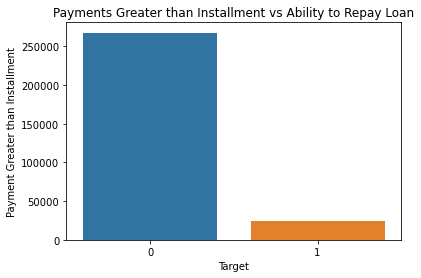

In [126]:
#plot X as TARGET: 1=difficuly, 0=no difficulty
#plot Y as number of times AMT_PAYMENT_GREATER_EQUAL_INSTALMENT: is 1 (yes) or 0 (no). 

#total_1 = application_train_new['AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'].value_counts()[1]
#total_0 = application_train_new['AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'].value_counts()[0]

df = application_train_new
total_0 = df.loc[df['TARGET'] == 0, 'AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'].sum()
total_1 = df.loc[df['TARGET'] == 1, 'AMT_PAYMENT_GREATER_EQUAL_INSTALMENT'].sum() 

x = [0, 1] #target categories
y = [total_0, total_1] 

p = sns.barplot(x,y )
p.set(xlabel = "Target", ylabel = "Payment Greater than Installment")
p.set_title('Payments Greater than Installment vs Ability to Repay Loan')
plt.show()


## **Part 2: Model Construction using Logistic Regression [10 Marks]**

* 2.1 Constructing the model [5 Marks]

Fit a logistic regression model using the selected explanatory variables and the training data.

In [127]:

# Select explanatory variables from cleaned train data 
X = application_train_new[['ENTRANCES_MEDI', 'AMT_GOODS_PRICE', 'CODE_GENDER', 'NONLIVINGAREA_MODE', 'AMT_CREDIT',
    'DAYS_REGISTRATION', 'AMT_CREDIT_MAX_OVERDUE', 'REG_REGION_NOT_WORK_REGION','NAME_FAMILY_STATUS', 'AMT_REQ_CREDIT_BUREAU_WEEK',
        'REG_CITY_NOT_WORK_CITY', 'NAME_HOUSING_TYPE','AMT_DRAWINGS_CURRENT', 'FLOORSMAX_AVG', 'OWN_CAR_AGE', 'AMT_TOTAL_RECEIVABLE',
            'ELEVATORS_AVG', 'AMT_INCOME_TOTAL','LIVINGAPARTMENTS_MEDI', 'CNT_INSTALMENT_FUTURE', 'FLAG_WORK_PHONE', 'COMMONAREA_MODE',
                'AMT_PAYMENT_GREATER_EQUAL_INSTALMENT', 'FLAG_OWN_REALTY', 'DAYS_EMPLOYED', 'EXT_SOURCE_3', 'NAME_CONTRACT_TYPE',
                'FLAG_EMP_PHONE', 'CREDIT_TYPE_CREDIT_CARD','CNT_FAM_MEMBERS', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLOORSMIN_AVG',
                'NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'FLOORSMIN_MEDI', 'WEEKDAY_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
                'DAYS_LAST_PHONE_CHANGE', 'REGION_RATING_CLIENT', 'OCCUPATION_TYPE', 'TARGET']]

#remove all rows with NA as any value for any feature
X.dropna(inplace=True)
#X.fillna(0)
# response vector is the TARGET feature
y = X.pop('TARGET')


In [128]:
from sklearn.linear_model import LogisticRegression

# Get  columns whose data type is not float64
filtered_cols = X.dtypes[X.dtypes != np.float64]
# list of columns whose data type is not float64
cols = list(filtered_cols.index)

# Use get_dummies to convert categorical columns into dummy columns of 0s and 1s for Logistic Regression 
X_encoded = pd.get_dummies(data=X, columns = cols)

# Split data into 70% trianing and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, test_size=0.30, random_state=0)

# Fit a logistic regression model to the train data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# determine predicted response from logistic regression X_test data
y_pred = logreg.predict(X_test)

* 2.2 Interpreting the model [5 Marks]

Interpret the estimated coefficients of the logistic regression model. 
Explain their impact on the response variable in plain English.

In [129]:
# Determine coefficients and inercept from Logistic Regression model
print(logreg.coef_, logreg.intercept_)

[[-6.51467816e-08 -4.35928328e-06 -1.73633549e-08 ... -9.01030783e-09
  -2.85254564e-08 -3.25987817e-09]] [-3.07343554e-07]


The coefficients of the logistic regression model, as well as the intercept, are numbers that are all very close to 0. This means that the resulting predictions will most likely be an array of 0. This means the model will do a good job predicting whether the customer has the ability to repay the loan, but may not necessarily predict the ability of a customer to have difficulty.  

## **Part 3: Model Evaluation [25 Marks]**

* 3.1 Confusion matrix [5 Marks] 

Calculate the confusion matrix using the testing set. 

In [130]:
# calculate confusion matrix and related values
cnf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cnf_matrix.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
print(y_test.value_counts())


True Negatives:  591
False Positives:  0
False Negatives:  35
True Positives:  0
0    591
1     35
Name: TARGET, dtype: int64


* 3.2 Explaining the confusion matrix [5 Marks]

Explain a weakness or a strength of the model based on the confusion matrix. 

According to the confusion matrix, the model predicted all customers who repaid their loans correctly. However, if incorrectly classified 35 customers who had difficulty as not having difficulty. 

* 3.3 Graphic illustration of the performance [5 Marks]

Plot the ROC curve (receiver operating characteristic curve) showing the performance of the model.
Calculate AUC (Area under the curve) respectively

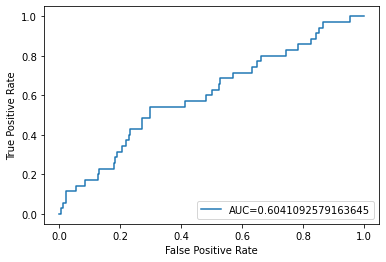

In [131]:
y_pred_probs = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ =roc_curve(y_test, y_pred_probs)

auc = roc_auc_score(y_test, y_pred_probs)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

The AUC of the model is about 0.604, implying that the model is not strong enough to predict targets correctly. 

* 3.4 Compute the performance measures [5 Marks]

Compute the following measures to assess the performance of the logistic regression model: 
    precision, recall, F_1-score, accuracy, and total misclassification rate; 
    using the testing set.

In [132]:

print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print('missclassification rate = ', 1-accuracy)



              precision    recall  f1-score   support

           0       0.94      1.00      0.97       591
           1       0.00      0.00      0.00        35

    accuracy                           0.94       626
   macro avg       0.47      0.50      0.49       626
weighted avg       0.89      0.94      0.92       626

missclassification rate =  0.05591054313099042


* 3.5 Suitable performance measures for reporting [5 Marks]

If you were to only choose two of the five performance measures for reporting, which ones do you choose? 
Justify your choice.

I would choose the F1-Score, as it combines both the precision and recall evaluations to get an overall understanding of the model performance. However, it is obvious that this model has issues with False Negatives, as it is missclassifying all Targets that had value "1". As a result, Recall would be another important metric to consider. 

## **Part 4: Alternative classification model [20 marks]**
Select an alternative classification model that has at least one tunable hyper-parameter.

**HINT !**

You might want to try random forest or boosted tree etc.

* 4.1 Train the alternative classification model [5 marks]

Train your alternative model on the same training set.

Train alternative model using Random Forest Classifier:

In [133]:
classifier = RandomForestClassifier(n_estimators=1000, criterion="gini")
classifier.fit(X_train, y_train)
y_pred_RF = classifier.predict(X_test)

* 4.2 Tune the alternative classification model [5 Marks]

Use a k-fold cross validation to tune the hyper-parameters of the alternative model based on accuracy. 

In [134]:
score_CV = cross_val_score(classifier, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % score_CV.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(classifier, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


Mean cross-validation score: 0.94
K-fold CV average score: 0.94


In [135]:
CV_inner = KFold(n_splits = 5, shuffle=True, random_state=1)
space = dict()
space['n_estimators'] = [10, 100, 500, 1000]
space['max_features'] = [2, 10,20, 40]
search = GridSearchCV(classifier, space, scoring='accuracy', n_jobs=1, cv=CV_inner, refit=True)
CV_outer = KFold(n_splits = 10, shuffle=True, random_state=1)
scores = cross_val_score(search, X_train, y_train, scoring ='accuracy', cv=CV_outer, n_jobs=-1)
print('Accuracy: %.3f' %(np.mean(scores)))

Accuracy: 0.938


In [136]:
y_pred_RF = classifier.predict(X_test)

* 4.3 Confusion matrix [5 Marks]

Calculate the confusion matrix using the testing set.

In [137]:
# calculate confusion matrix and related values
cnf_matrix = confusion_matrix(y_test, y_pred_RF)
tn, fp, fn, tp = cnf_matrix.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

print(classification_report(y_test,y_pred_RF))
accuracy = accuracy_score(y_test, y_pred_RF)
print('missclassification rate = ', 1-accuracy)

True Negatives:  591
False Positives:  0
False Negatives:  35
True Positives:  0
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       591
           1       0.00      0.00      0.00        35

    accuracy                           0.94       626
   macro avg       0.47      0.50      0.49       626
weighted avg       0.89      0.94      0.92       626

missclassification rate =  0.05591054313099042


* 4.4 Graphic illustration of the performance [5 Marks]

Plot the ROC curve (receiver operating characteristic curve) showing the performance of the model.
Calculate AUC (Area under the curve) respectively

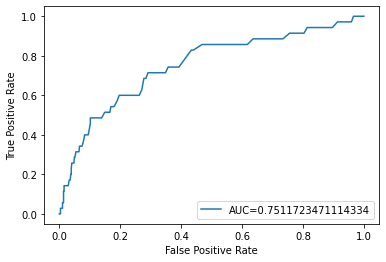

In [139]:
y_pred_probs = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ =roc_curve(y_test, y_pred_probs)

auc = roc_auc_score(y_test, y_pred_probs)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## **Part 5: Compare the two models [15 Marks]**

Use the test data to compare the logistic regression model and the tuned alternative model.

* 5.1 Compare predictive performance [5 Marks]

Choose a suitable plot and illustrate all the five performance measures (precision, recall, F_1-score, accuracy, and total misclassification rate) for the two models. 
Use appropriate figure size, title/caption, legend, and axis titles.

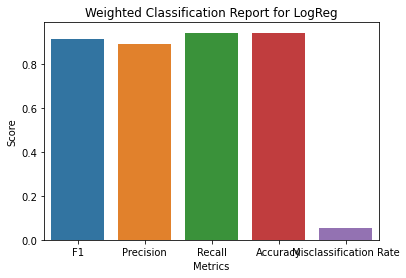

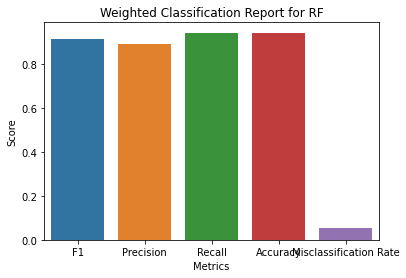

In [174]:
logreg_f1 = f1_score(y_test, y_pred, average='weighted')
logreg_precission = precision_score(y_test, y_pred, average='weighted')
logreg_recall = recall_score(y_test, y_pred, average='weighted')
logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_misclass = 1-logreg_accuracy

logreg_metrics = [logreg_f1, logreg_precission, logreg_recall, logreg_accuracy, logreg_misclass]

x_axis = ['F1', 'Precision', 'Recall', 'Accuracy', 'Misclassification Rate']

p = sns.barplot(x_axis, logreg_metrics)
p.set(xlabel = "Metrics", ylabel = "Score")
p.set_title('Weighted Classification Report for LogReg')

plt.show()

RF_f1 = f1_score(y_test, y_pred_RF, average='weighted')
RF_precission = precision_score(y_test, y_pred_RF, average='weighted')
RF_recall = recall_score(y_test, y_pred_RF, average='weighted')
RF_accuracy = accuracy_score(y_test, y_pred_RF)
RF_misclass = 1-logreg_accuracy

RF_metrics = [RF_f1, RF_precission, RF_recall, RF_accuracy, RF_misclass]

x_axis = ['F1', 'Precision', 'Recall', 'Accuracy', 'Misclassification Rate']

p = sns.barplot(x_axis, RF_metrics)
p.set(xlabel = "Metrics", ylabel = "Score")
p.set_title('Weighted Classification Report for RF')

plt.show()


* 5.2 Recommend model to client (scenario 1) [5 Marks]

Among the two models you have developed, what is you suggested model to Home Credit Group (client of the project), 
if they are more concerned about rejecting applications of individuals who may otherwise end up having difficulty in repayment? 
 Provide a numeric measure for each of the two models to justify your response.


Both models have the same Classification Report. This means that both models predicted "0" as the Target values for each application. Per the classification report for category "1", as required by the client to reject applications, it is obvious from the score of the models that neither model is feasible, specifically since the metrics are of 0 value. This can be simply attested to the fact that the number of applications that were accepted (i.e. scored 0) are far greater than those rejected (i.e. scored 1). As a result, there has been insufficient data for the model to be trained on rejecting applications as it can be seen as almost negligible due to the 5.5% misclassification error rate. This would cause the models to overfit on accepted applications. 

* 5.3 Recommend model to client (scenario 2) [5 Marks]

Among the two models you have developed, what is you suggested model to Home Credit Group (client of the project), 
if they are more concerned about not rejecting applications of individuals who may be capable of repayment according to the data? 
 Provide a numeric measure for each of the two models to justify your response.

Again, both models have the same Classification Report. Both models do an excellent job not accepting applications given they predict Target values of "0" from the given data. The F1 scores are all greater than 0.94 for both models and the misclassification rate is 5.5%. This means 94.5% of the time, the model is accurately predicting the applications should not be rejected. The choice of model will boil down to the AUC score of each models respective ROC curve. It is obvious that the AUC score of the Random Forest Classification model is greater than that of the Logistic Regression model (i.e. 0.75 vs 0.64). From this alone, we can suggest using the Random Forest Classification model to be used by the client. 